# MLP definit si antrenat cu PyTorch

Implementati un model de clasificare MLP pentru recunoasterea celor 10 tipuri de cifre din setul MNIST. Implementarea se va face folosind PyTorch. Setul de date va fi un obiect de tip [MNIST Dataset](https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html). 

Puteti extinde codul din exemplul PyTorch pentru regresia logistica; trebuie, in principal, sa adaugati straturi ascunse si sa stabiliti functia de eroare. 

Cerinte/observatii:
1. metoda de initializare pentru MLP va primi: numarul de noduri de intrare -- pentru MNIST: 784; numarul de clase de iesire -- 10 in acest caz; numarul de neuroni din straturile ascunse, ca lista de intregi: de exemplu, [300, 150, 40] arata ca avem 3 straturi ascunse, cu cate 300, 150 si respectiv 40 de neuroni.
1. de asemenea, metoda de initializare va primi un indicativ al functiei de activare care se folosesc in straturile ascunse -- [sigmoida logistica](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html), [tangenta hiperbolica](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html), [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU), [SELU](https://pytorch.org/docs/stable/generated/torch.nn.SELU.html#torch.nn.SELU), [PReLU](https://pytorch.org/docs/stable/generated/torch.nn.PReLU.html#torch.nn.PReLU) [etc](https://pytorch.org/docs/stable/nn.html#id1). Puteti alege ca fiecarui strat ascuns sa ii fie indicata o functie de activare.
1. se va afisa reteaua si sumarul retelei, folosind **[torchinfo](https://github.com/TylerYep/torchinfo)**; de preferat **torchinfo** lui <s>torchsummary</s>.
1. la instantierea obiectului Dataset MNIST se va folosi sirul de transformari indicat mai jos.
1. in functia `forward` a modelului se va face aducerea intrarilor de la forma [B, 1, 28, 28] la [B, 768], unde B este dimensiunea minibatchului; obiectul Dataset MNIST din PyTorch returneaza o cifra ca o matrice de valori, pe un singur canal (imagine in otnuri de gri); functia `forward` va produce o iesire de forma [B, 10], unde cele 10 valori vor fi logitii furnizati ulterior functiei `torch.nn.CrossEntropyLoss`.
1. creati o matrice de confuzie pentru clase; puteti folosi [scikit learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html). Experimentati cu diferiti [optimizatori](https://pytorch.org/docs/stable/optim.html).
1. scrieti intr-un tabel valorile de acuratete obtinute pentru setul de antrenare si cel de testare. Folositi cel putin 3 variante de functii de activare in straturile ascunse. Pentru fiecare experiment, prezentati in acelasi grafic loss-ul pe setul antrenare si pe testare si intr-un alt grafic acuratetea pe setul de antrenare si pe cel de testare.

## Incarcarea si transformarea setului de date MNIST

In [1]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

In [3]:
# subsetul de antrenare
train_ds = MNIST('./data', train=True, download=True, transform=transform)
# pentru subsetul de testare se foloseste `train=False`
test_ds = MNIST('./data', train=False, download=True, transform=transform)

In [4]:
# primul minibatch
for data, label in train_ds:
    print(data.shape, data.min(), data.max())
    break
# fiecare imagine de cifra este o imagine pe un singur canal, matrice de 28x28, valorile initiale 0..255 sunt aduse in [-1, 1] prin transformare

torch.Size([1, 28, 28]) tensor(-1.) tensor(1.)


In [5]:
train_loader =  DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=128, shuffle=False)

In [6]:
for data, label in train_loader:
    print(data.shape)
    # reshape:
    data = data.view(data.shape[0], -1)
    print(data.shape)
    break

torch.Size([128, 1, 28, 28])
torch.Size([128, 784])


In [10]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import torchinfo
from typing import List, Union
from typing import Tuple
from typing import Dict

class MLP(nn.Module):
    def __init__(self, input_size: int, output_size: int, hidden_sizes: List[int], 
                 activation: List[Union[nn.Module, nn.functional]]) -> None:
        super(MLP, self).__init__()
        self.input_size: int = input_size
        self.output_size: int = output_size
        self.hidden_sizes: List[int] = hidden_sizes
        self.activation: List[Union[nn.Module, nn.functional]] = activation
        
        layers: List[nn.Module] = []
        prev_size: int = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(activation)
            prev_size = hidden_size
        layers.append(nn.Linear(prev_size, output_size))
        
        self.model = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x: torch.Tensor = x.view(-1, self.input_size)
        return self.model(x)


In [11]:
def train(model: torch.nn.Module, train_loader: DataLoader, optimizer: torch.optim.Optimizer,
          criterion: torch.nn.Module, device: torch.device) -> tuple[float, float]:
    """
    Antrenează modelul pe datele de antrenare.

    Args:
        model (torch.nn.Module): Modelul de rețea neurală.
        train_loader (DataLoader): Obiectul DataLoader pentru setul de date de antrenare.
        optimizer (torch.optim.Optimizer): Optimizatorul pentru antrenare.
        criterion (torch.nn.Module): Funcția de loss (criteriul de antrenare).
        device (torch.device): Dispozitivul pe care rulează antrenarea (CPU sau CUDA).

    Returns:
        tuple[float, float]: Pierderea medie și acuratețea de antrenare.
    """
    model.train()
    running_loss: float = 0.0
    correct: int = 0
    total: int = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss: float = running_loss / len(train_loader)
    train_acc: float = correct / total * 100.0
    return train_loss, train_acc

In [12]:
def test(model: torch.nn.Module, test_loader: DataLoader, criterion: torch.nn.Module,
         device: torch.device) -> Tuple[float, float]:
    """
    Evaluează modelul pe datele de testare.

    Args:
        model (torch.nn.Module): Modelul de rețea neurală.
        test_loader (DataLoader): Obiectul DataLoader pentru setul de date de testare.
        criterion (torch.nn.Module): Funcția de loss (criteriul de evaluare).
        device (torch.device): Dispozitivul pe care rulează evaluarea (CPU sau CUDA).

    Returns:
        tuple[float, float]: Pierderea medie și acuratețea de testare.
    """
    model.eval()
    running_loss: float = 0.0
    correct: int = 0
    total: int = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    test_loss: float = running_loss / len(test_loader)
    test_acc: float = correct / total * 100
    return test_loss, test_acc

Rețeaua:
MLP(
  (activation): Sigmoid()
  (model): Sequential(
    (0): Linear(in_features=784, out_features=300, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=300, out_features=150, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=150, out_features=40, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=40, out_features=10, bias=True)
  )
)

Sumarul rețelei:
Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [128, 10]                 --
├─Sequential: 1-1                        [128, 10]                 --
│    └─Linear: 2-1                       [128, 300]                235,500
│    └─Sigmoid: 2-2                      [128, 300]                --
│    └─Linear: 2-3                       [128, 150]                45,150
│    └─Sigmoid: 2-4                      [128, 150]                --
│    └─Linear: 2-5                       [128, 40]                 6,040
│    └─Sigmoid: 2-6               

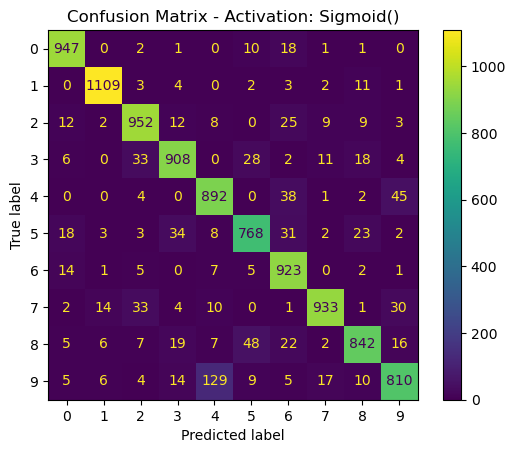

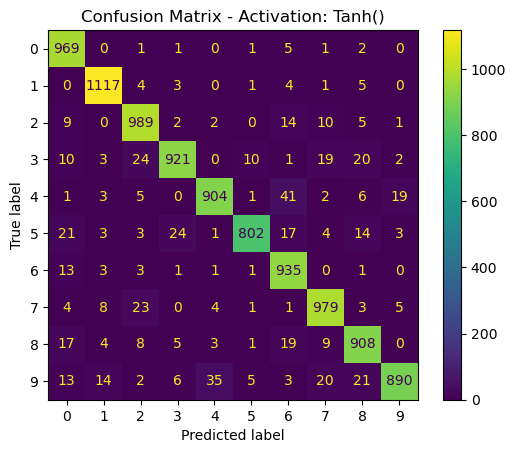

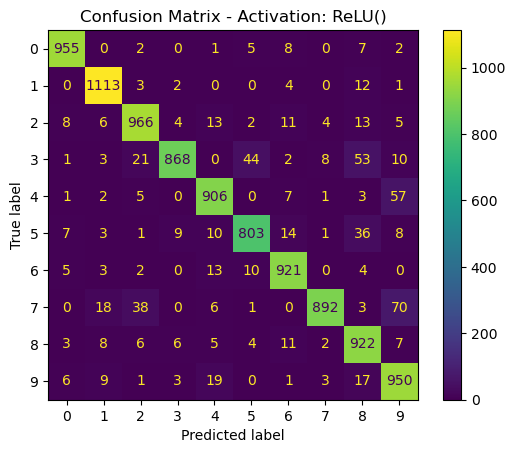

In [13]:
input_size: int = 784
output_size: int = 10
hidden_sizes: List[int] = [300, 150, 40]
activations: List[nn.Module] = [nn.Sigmoid(), nn.Tanh(), nn.ReLU()]

device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs: int = 10
lr: float = 0.001
ok: bool = True

conf_matrices: List[np.ndarray] = []
# Lista de dictionare pentru stocarea rezultatelor experimentelor.
# Fiecare dictionar contine informatii despre un experiment,
# cum ar fi tipul de activare, pierderile si acuratetea pentru
# setul de antrenare si testare
results: List[Dict[str, Union[str, List[float]]]] = []
for activation in activations:
    model = MLP(input_size, output_size, hidden_sizes, activation).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    if ok :
        print("Rețeaua:")
        print(model)
        summary = torchinfo.summary(model, input_size=(128, input_size))
        print("\nSumarul rețelei:")
        print(summary)
        ok = False
    
    train_losses: List[float] = []
    test_losses: List[float] = []
    train_accuracies: List[float] = []
    test_accuracies: List[float] = []
    
    for epoch in range(epochs):
        train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
        test_loss, test_acc = test(model, test_loader, criterion, device)
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        
        print(f"Epoch {epoch+1}/{epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
    
    results.append({
        'activation': str(activation),
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies
    })
    all_preds: List[int] = []
    all_labels: List[int] = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    conf_matrix = confusion_matrix(all_labels, all_preds)
    conf_matrices.append(conf_matrix)

for i, activation in enumerate(activations):
    cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrices[i], display_labels=range(10))
    cm_display.plot(cmap='viridis', values_format='d')
    plt.title(f'Confusion Matrix - Activation: {str(activation)}')
    plt.show()


{'activation': 'ReLU()', 'train_losses': [0.44187036258325396], 'test_losses': [0.22718448888604778], 'train_accuracies': [86.60166666666666], 'test_accuracies': [92.96]}


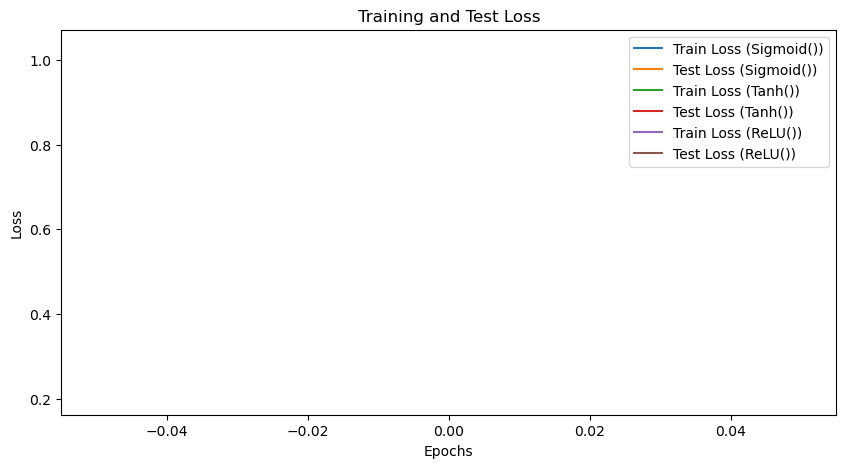

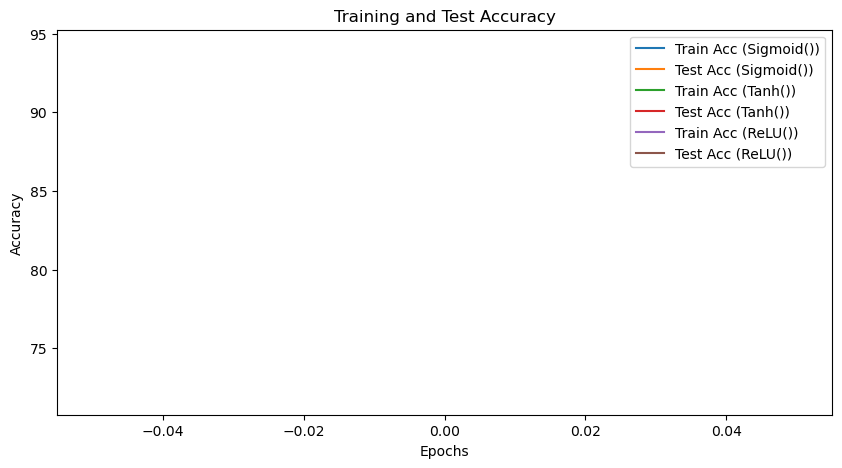

In [15]:
plt.figure(figsize=(10, 5))
for result in results:
    plt.plot(result['train_losses'], label=f"Train Loss ({result['activation']})")
    plt.plot(result['test_losses'], label=f"Test Loss ({result['activation']})")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Test Loss')
plt.show()

plt.figure(figsize=(10, 5))
for result in results:
    plt.plot(result['train_accuracies'], label=f"Train Acc ({result['activation']})")
    plt.plot(result['test_accuracies'], label=f"Test Acc ({result['activation']})")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Test Accuracy')
plt.show()
